# <span style="color:blue">LDA model (2019_Sep) - 10 topics</span>

In [1]:
yyyy_MMM = '2019_Sep'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Sep\2019_Sep_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model\2019_Sep\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
2864714    ['tie', 'tie', 'tee', 'wood', 'switch', 'helen...
3178241    ['weekend', 'gucci', 'gucci', 'addict', 'gucci...
2344700    ['repost', 'sergey', 'boga', 'fashion', 'cloth...
2623621                                  ['coffee', 'break']
2124916    ['moth', 'settle', 'long', 'photograph', 'feel...
2010479    ['position', 'berlin', 'fair', 'artist', 'luoy...
1926541    ['start', 'sienna', 'opalescent', 'mitzvah', '...
2030012    ['healthy', 'chicken', 'soup', 'comfort', 'bow...
2409159    ['makeup', 'artist', 'bane', 'glitter', 'cover...
1718831    ['owen', 'yesterday', 'display', 'italia', 'be...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
2199126    ['head', 'burbs', 'today', 'play', 'dome', 'ka...
2478664    ['recharge', 'perform', 'celine', 'cycling', '...
1897859    ['lady', 'hale', 'fabulous', 'spider', 'brooch...
3236684    ['sponsor', 'average', 'sponsor', 'post', 'hon...
1837594    ['realignment', 'doctor', 'beau', 'chiropracto...
2405469    ['chicken', 'pickle', 'spice', 'char', 'urgh',...
2575090    ['witness', 'great', 'performer', 'time', 'exp...
3245329    ['demi', 'lovato', 'music', 'career', 'peaked'...
2597366             ['mercedes', 'love', 'white', 'fashion']
2845564    ['sip', 'true', 'protein', 'save', 'order', 'd...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(135913,)


<AxesSubplot:>

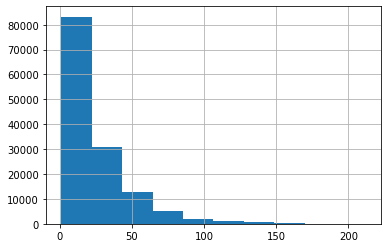

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save document-term matrix

In [13]:
# save document-term matrix
savetxt(file_model + '_document_term_matrix.csv', corpus_total, delimiter=',', fmt='% s')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build LDA model

In [14]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:43.44


### Incremental learning

In [15]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:45.83
1  -----  500  -----  749
time elapsed - 00:00:44.71
2  -----  750  -----  999
time elapsed - 00:00:43.67
3  -----  1000  -----  1249
time elapsed - 00:00:43.87
4  -----  1250  -----  1499
time elapsed - 00:00:44.61
5  -----  1500  -----  1749
time elapsed - 00:00:43.44
6  -----  1750  -----  1999
time elapsed - 00:00:42.56
7  -----  2000  -----  2249
time elapsed - 00:00:44.24
8  -----  2250  -----  2499
time elapsed - 00:00:43.60
9  -----  2500  -----  2749
time elapsed - 00:00:43.54
10  -----  2750  -----  2999
time elapsed - 00:00:44.33
11  -----  3000  -----  3249
time elapsed - 00:00:45.87
12  -----  3250  -----  3499
time elapsed - 00:00:43.70
13  -----  3500  -----  3749
time elapsed - 00:00:43.68
14  -----  3750  -----  3999
time elapsed - 00:00:43.51
15  -----  4000  -----  4249
time elapsed - 00:00:43.58
16  -----  4250  -----  4499
time elapsed - 00:00:44.00
17  -----  4500  -----  4749
time elapsed - 00:00:44.62
18  -----  4750  -----  4999
time 

time elapsed - 00:00:44.80
144  -----  36250  -----  36499
time elapsed - 00:00:46.15
145  -----  36500  -----  36749
time elapsed - 00:00:48.15
146  -----  36750  -----  36999
time elapsed - 00:00:45.34
147  -----  37000  -----  37249
time elapsed - 00:00:45.51
148  -----  37250  -----  37499
time elapsed - 00:00:45.50
149  -----  37500  -----  37749
time elapsed - 00:00:44.19
150  -----  37750  -----  37999
time elapsed - 00:00:44.43
151  -----  38000  -----  38249
time elapsed - 00:00:43.79
152  -----  38250  -----  38499
time elapsed - 00:00:44.22
153  -----  38500  -----  38749
time elapsed - 00:00:44.77
154  -----  38750  -----  38999
time elapsed - 00:00:44.07
155  -----  39000  -----  39249
time elapsed - 00:00:45.14
156  -----  39250  -----  39499
time elapsed - 00:00:45.28
157  -----  39500  -----  39749
time elapsed - 00:00:45.52
158  -----  39750  -----  39999
time elapsed - 00:00:45.21
159  -----  40000  -----  40249
time elapsed - 00:00:48.51
160  -----  40250  -----  404

time elapsed - 00:00:44.65
283  -----  71000  -----  71249
time elapsed - 00:00:44.07
284  -----  71250  -----  71499
time elapsed - 00:00:43.54
285  -----  71500  -----  71749
time elapsed - 00:00:45.16
286  -----  71750  -----  71999
time elapsed - 00:00:45.47
287  -----  72000  -----  72249
time elapsed - 00:00:44.94
288  -----  72250  -----  72499
time elapsed - 00:00:45.78
289  -----  72500  -----  72749
time elapsed - 00:00:46.75
290  -----  72750  -----  72999
time elapsed - 00:00:45.52
291  -----  73000  -----  73249
time elapsed - 00:00:44.81
292  -----  73250  -----  73499
time elapsed - 00:00:44.66
293  -----  73500  -----  73749
time elapsed - 00:00:46.52
294  -----  73750  -----  73999
time elapsed - 00:00:48.21
295  -----  74000  -----  74249
time elapsed - 00:00:46.17
296  -----  74250  -----  74499
time elapsed - 00:00:45.14
297  -----  74500  -----  74749
time elapsed - 00:00:45.28
298  -----  74750  -----  74999
time elapsed - 00:00:45.14
299  -----  75000  -----  752

time elapsed - 00:00:50.12
422  -----  105750  -----  105999
time elapsed - 00:00:50.42
423  -----  106000  -----  106249
time elapsed - 00:00:52.41
424  -----  106250  -----  106499
time elapsed - 00:00:52.94
425  -----  106500  -----  106749
time elapsed - 00:00:52.86
426  -----  106750  -----  106999
time elapsed - 00:00:49.34
427  -----  107000  -----  107249
time elapsed - 00:00:48.03
428  -----  107250  -----  107499
time elapsed - 00:00:48.12
429  -----  107500  -----  107749
time elapsed - 00:00:51.95
430  -----  107750  -----  107999
time elapsed - 00:00:52.34
431  -----  108000  -----  108249
time elapsed - 00:00:51.34
432  -----  108250  -----  108499
time elapsed - 00:00:51.86
433  -----  108500  -----  108749
time elapsed - 00:00:51.30
434  -----  108750  -----  108999
time elapsed - 00:00:50.34
435  -----  109000  -----  109249
time elapsed - 00:00:50.95
436  -----  109250  -----  109499
time elapsed - 00:00:51.99
437  -----  109500  -----  109749
time elapsed - 00:00:48.

### Topics in LDA model

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"house" + 0.027*"change" + 0.027*"festival" + 0.019*"school" + '
  '0.019*"climate" + 0.019*"rock" + 0.015*"sister" + 0.015*"hardstyle" + '
  '0.015*"treat" + 0.014*"strike"'),
 (1,
  '0.066*"fashion" + 0.053*"style" + 0.033*"blogger" + 0.027*"life" + '
  '0.024*"week" + 0.020*"outfit" + 0.017*"love" + 0.016*"fall" + 0.015*"time" '
  '+ 0.015*"today"'),
 (2,
  '0.038*"florida" + 0.034*"music" + 0.019*"event" + 0.019*"energy" + '
  '0.015*"sale" + 0.015*"shoot" + 0.015*"code" + 0.015*"contour" + '
  '0.012*"male" + 0.011*"movie"'),
 (3,
  '0.025*"support" + 0.019*"help" + 0.019*"wine" + 0.019*"join" + '
  '0.019*"custom" + 0.017*"visit" + 0.017*"fitness" + 0.017*"amaze" + '
  '0.017*"body" + 0.017*"community"'),
 (4,
  '0.040*"morning" + 0.033*"plan" + 0.030*"loop" + 0.027*"experience" + '
  '0.023*"power" + 0.020*"store" + 0.020*"comment" + 0.017*"repost" + '
  '0.017*"macmillan" + 0.013*"photographer"'),
 (5,
  '0.095*"beauty" + 0.029*"face" + 0.024*"nail" + 0.023*"brow"

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


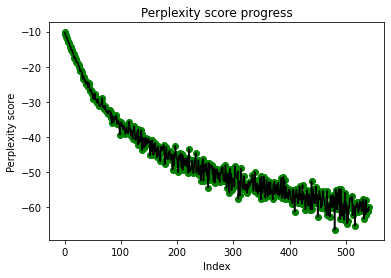

In [17]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


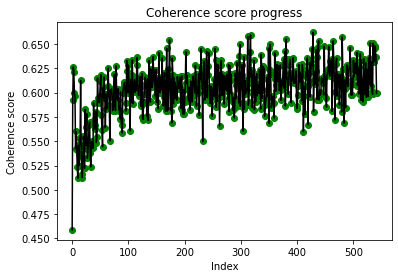

In [18]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.391332  0.242988       1        1  30.610153
5      0.194658 -0.384171       2        1  15.051451
6     -0.025453 -0.083220       3        1  10.814240
3     -0.044035  0.050147       4        1   8.638861
4     -0.028676 -0.038661       5        1   7.305490
2     -0.115580  0.085120       6        1   6.427534
0     -0.094785  0.036401       7        1   6.383659
8     -0.070038  0.042966       8        1   5.659531
7     -0.104293  0.028452       9        1   4.951858
9     -0.103130  0.019978      10        1   4.157223, topic_info=              Term       Freq      Total Category  logprob  loglift
115         beauty  58.000000  58.000000  Default  30.0000  30.0000
152        fashion  82.000000  82.000000  Default  29.0000  29.0000
15            food  40.000000  40.000000  Default  28.0000  28.0000
235          style  66.000000  66.000000  Default  27.0000  27.0000
92         blogger  40.000000  40.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
1216        cooper   1.982529   1.984276  Topic10  -4.4465   3.1794
4921        puglia   1.982463   1.984252  Topic10  -4.4465   3.1794
41904       trulli   1.982457   1.984252  Topic10  -4.4465   3.1794
41903  alberobello   1.982457   1.984252  Topic10  -4.4465   3.1794
20527         teau   1.982507   1.984328  Topic10  -4.4465   3.1794

[353 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
3385       8  1.009935       access
575        9  0.991958       agency
41903     10  1.007936  alberobello
6114       9  0.992415       alyson
1119       4  1.025562        amaze
...      ...       ...          ...
225        4  1.025533         wine
138        1  0.976085        woman
1045       4  1.025260         word
191        1  0.975791         work
139        1  0.985410         year

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 4, 5, 3, 1, 9, 8, 10])

### Save document-topic matrix (most significant topic per document)  
 https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
 https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document  Topic  Probability
0        2199126      1     0.683312
1        2478664      4     0.395565
2        1897859      0     0.425261
3        3236684      1     0.473197
4        1837594      1     0.330480
...          ...    ...          ...
135908   3073430      1     0.287915
135909   2814992      1     0.372722
135910   2737077      1     0.775051
135911   2979322      3     0.525050
135912   3146733      1     0.286250

[135913 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [21]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0        2199126  0.016664  0.683312  0.016664  0.016664  0.016664  0.016664   
1        2478664  0.005565  0.172543  0.005565  0.005565  0.395562  0.061130   
2        1897859  0.425261  0.174817  0.008326  0.091587  0.008325  0.091583   
3        3236684  0.006663  0.473197  0.006664  0.340164  0.006663  0.139996   
4        1837594  0.008056  0.330481  0.008056  0.169515  0.281957  0.008056   
...          ...       ...       ...       ...       ...       ...       ...   
135908   3073430  0.005488  0.287905  0.284071  0.115563  0.164321  0.060262   
135909   2814992  0.009091  0.372722  0.009091  0.190903  0.009091  0.281827   
135910   2737077  0.024994  0.775051  0.024994  0.024994  0.024994  0.024994   
135911   2979322  0.024996  0.024996  0.024996  0.525050  0.024996  0.024996   
135912   3146733  0.224560  0.286253  0.005467  0.115306  0.249715  0.005467   

          Topic6    Topic7    Topic8   

### Save topic-term matrix

In [22]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
